# Random forest classifier for NMD prediction

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#preprocessing
from sklearn import preprocessing

In [2]:
negative_df = pd.read_csv('random_balanced_negative_set_state_100_insign_no_NMD_pub.csv', index_col = 0)
positive_df = pd.read_csv('long_read_sleuth_dKD_up_filtered_features.csv', index_col = 0)

In [3]:
#Label
negative_df['NMD_sensitivity'] = 0
positive_df['NMD_sensitivity'] = 1

In [4]:
NMD_features_df =pd.concat([negative_df, positive_df], axis=0, join='outer')
NMD_features_df.columns

Index(['name_tar', 'start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', 'ORF_id', '50_nt',
       'stop_TGA', 'stop_TAA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'stop_150bp_from_start', '4th_stop_C',
       '4th_stop_G', '4th_stop_T', 'GC_perc_30_bp_round_stop',
       'GC_perc_up_15_bp_stop', 'GC_perc_down_15_bp_stop',
       'nr_exons_in_transcript', 'nr_exons_in_3prime',
       'UPF1_motifs_in3prime_total', 'UPF1_motifs_in3prime_relative',
       'NMD_sensitivity'],
      dtype='object')

In [5]:
NMD_features_df.dropna(inplace=True)
X = NMD_features_df.drop(['name_tar', 'start_ORF', 'end_ORF', 
                          'GC_perc_30_bp_round_stop',
                          'UPF1_motifs_in3prime_relative', 
                          'ORF_id', 'NMD_sensitivity'
                            ], axis=1)

y = NMD_features_df['NMD_sensitivity']

#normlaize X
for variable in ['nr_exons_in_3prime', 'exon_with_stop_length', 'last_exon_length', 
                 'distance_stop_EJC', '3_UTR_length',  '5_UTR_length', 't_length',
               'distance_stop_from_start', 'nr_exons_in_transcript']:
    X[variable]=(X[variable]-X[variable].mean())/X[variable].std()

#X['distance_stop_EJC']=(X['distance_stop_EJC']-X['distance_stop_EJC'].mean())/X['distance_stop_EJC'].std()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
len(X[X['4th_stop_G'].isna()].index)

0

In [7]:
print(sum(y_test))
print(len(y_test))

667
1309


# Automatic number of features

In [10]:
from sklearn.feature_selection import SequentialFeatureSelector
forward_selector = SequentialFeatureSelector(RandomForestClassifier(),
                                             n_features_to_select = 'auto',
                                             scoring = 'accuracy', 
                                             cv = 5).fit(X_train, y_train)

In [11]:
X_train.columns[forward_selector.support_]

Index(['exon_with_stop_length', '50_nt', 'stop_TGA', 'stop_TAA',
       'stop_150bp_from_start', '4th_stop_C', '4th_stop_G', '4th_stop_T',
       'nr_exons_in_transcript'],
      dtype='object')

In [12]:
X_small = X.loc[:, forward_selector.support_]
print(X_small.columns)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train_small, y_train_small)
y_pred = rf.predict(X_test_small)

accuracy = accuracy_score(y_test_small, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test_small, y_pred, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")


Index(['exon_with_stop_length', '50_nt', 'stop_TGA', 'stop_TAA',
       'stop_150bp_from_start', '4th_stop_C', '4th_stop_G', '4th_stop_T',
       'nr_exons_in_transcript'],
      dtype='object')
Accuracy: 0.6348357524828113
RMSE of the base model: 0.604


/Users/christina/miniforge3/envs/pygtftk/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Forward backward selection

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector
features_to_use = []
forward_selector = SequentialFeatureSelector(RandomForestClassifier(),
                                             n_features_to_select = 1,
                                             scoring = 'accuracy', 
                                             cv = 5).fit(X_train, y_train)
X_train.columns[forward_selector.support_]

X_down = X.loc[:, forward_selector.support_]
print(X_down.columns)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_down, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train_small, y_train_small)
y_pred = rf.predict(X_test_small)

accuracy = accuracy_score(y_test_small, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test_small, y_pred, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")


array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

Index(['50_nt'], dtype='object')

In [107]:
from sklearn.feature_selection import RFE
rf = RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=12)
fit = rfe.fit(X_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 12
Selected Features: [ True  True  True  True  True False  True  True False False False False
  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 5 1 1 4 3 2 6 1 1 1 1 1]


In [108]:
X_7_feat = X.loc[:, fit.support_]
print(X_7_feat.columns)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_7_feat, y, test_size=0.2)


Index(['exon_with_stop_length', 'last_exon_length', 'distance_stop_EJC',
       '50_nt', 'stop_TGA', '3_UTR_length', 'distance_stop_from_start',
       'GC_perc_up_15_bp_stop', 'GC_perc_down_15_bp_stop',
       'nr_exons_in_transcript', 'nr_exons_in_3prime',
       'UPF1_motifs_in3prime_total'],
      dtype='object')


In [109]:
rf.fit(X_train_small, y_train_small)
y_pred = rf.predict(X_test_small)

In [110]:
accuracy = accuracy_score(y_test_small, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test_small, y_pred, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

Accuracy: 0.7051184110007639
RMSE of the base model: 0.543


/Users/christina/miniforge3/envs/pygtftk/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


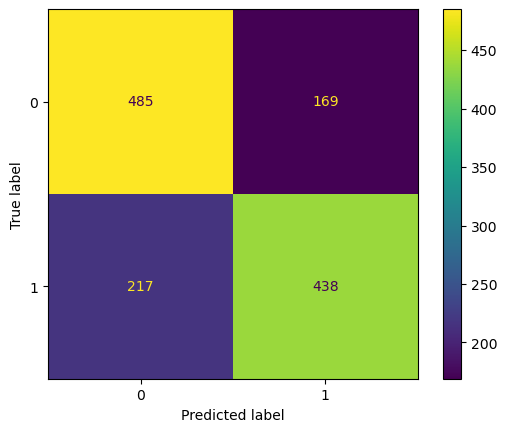

In [111]:
# Create the confusion matrix
cm = confusion_matrix(y_test_small, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [11]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
50_nt,-0.003427,0.002214
UPF1_motifs_in3prime_total,-0.003351,0.001933
3_UTR_length,-0.003123,0.002899
distance_stop_from_start,-0.000305,0.002213
distance_stop_EJC,0.002513,0.004016
4th_stop_C,0.002894,0.004359
4th_stop_T,0.003199,0.002280
exon_with_stop_length,0.004570,0.005492
nr_exons_in_3prime,0.004798,0.003491
last_exon_length,0.016070,0.005549


In [16]:
X_test.loc[y_test.index, "50_nt"]

MSTRG.11025.2      0.923329
ENST00000706246    0.923329
ENST00000393708   -1.082872
ENST00000498104    0.923329
ENST00000284719   -1.082872
                     ...   
ENST00000674862   -1.082872
ENST00000539904    0.923329
ENST00000591650   -1.082872
ENST00000580287    0.923329
MSTRG.26484.1      0.923329
Name: 50_nt, Length: 1313, dtype: float64

In [ ]:
#Baseline: better than 50nt rule alone
y_pred_50 = NMD_features_df.loc[y_test.index, "50_nt"]
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## Sequential feature selection

In [119]:
from sklearn.feature_selection import SequentialFeatureSelector
forward_selector = SequentialFeatureSelector(RandomForestClassifier(),
                                             n_features_to_select = 6,
                                             scoring = 'accuracy', 
                                             cv = 5).fit(X_train, y_train)

In [120]:
forward_selector.support_

array([False, False, False,  True,  True,  True, False, False,  True,
        True, False, False, False, False,  True, False, False])

In [121]:
#select features
X_7_feat = X.loc[:, forward_selector.support_]
print(X_7_feat.columns)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_7_feat, y, test_size=0.2)

#fit classifier
rf = RandomForestClassifier()
rf.fit(X_train_small, y_train_small)
y_pred = rf.predict(X_test_small)

#get prediction evaluation
accuracy = accuracy_score(y_test_small, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test_small, y_pred, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

Index(['50_nt', 'stop_TGA', 'stop_TAA', 'stop_150bp_from_start', '4th_stop_C',
       'nr_exons_in_transcript'],
      dtype='object')
Accuracy: 0.6615737203972498
RMSE of the base model: 0.582


/Users/christina/miniforge3/envs/pygtftk/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
